# Testing Navier-Stokes in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Non-linear term basic calculation

In [103]:
nx = 25
ny = 30
i = 12; j = 15;
w = Nodes(Dual,(nx,ny))
#w[i,j] = 1.0;
w .= rand(size(w));

In [94]:
L = plan_laplacian(w,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 25, ny = 30) grid with spacing 1.0

In [104]:
ψ = L\w
q = curl(ψ);

Set up dual edge data structures for shifting

In [105]:
p = Edges(Dual,w);
r = deepcopy(p);

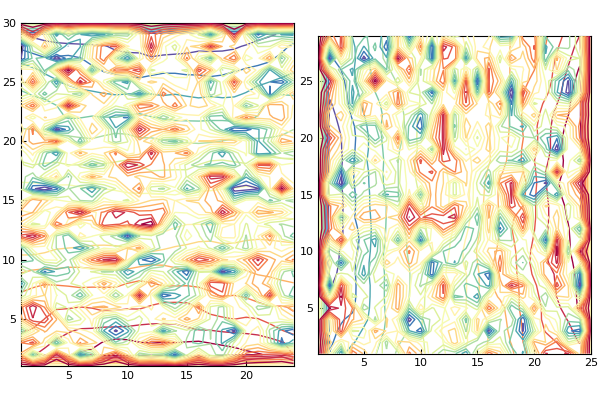

In [106]:
shift!(p,q);
shift!(r,w);
plot(p)
plot!(r)

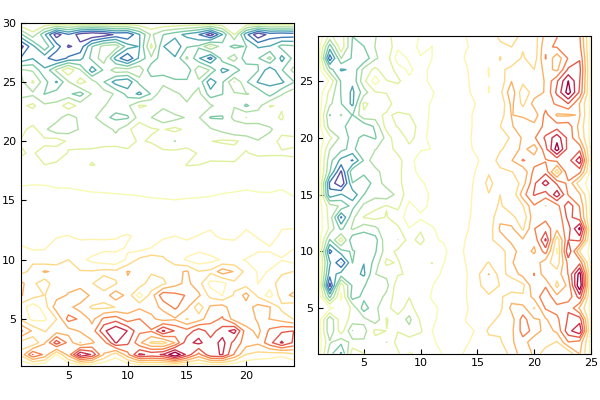

In [107]:
plot(p∘r)

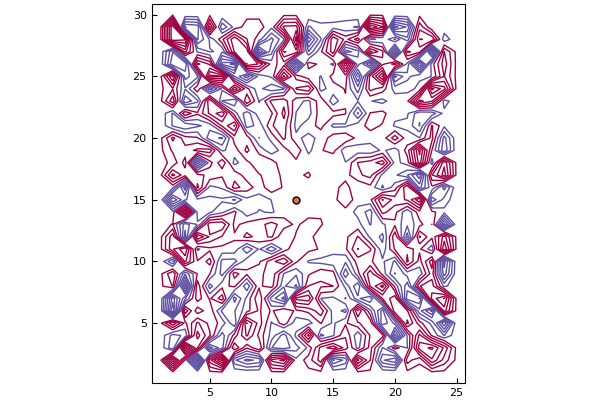

In [108]:
plot(divergence(p∘r),clim=(-1e-7,1e-7))
scatter!([i],[j],markersize=5,fillcolor=:black)

### Timing

In [7]:
srand(1);

In [4]:
nx = 129; ny = 129;
w = Nodes(Dual,(nx,ny))
w .= rand(size(w));
Qq = Edges(Dual,w);
Ww = deepcopy(Qq);
ψ = deepcopy(w);

In [137]:
L = plan_laplacian(w,with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 129, ny = 130) grid with spacing 1.0

In [141]:
@time nl = divergence(shift!(Qq,curl(L\w))∘shift!(Ww,w));

  0.010047 seconds (20 allocations: 782.969 KiB)


### Solve the Lamb-Oseen vortex

First, construct the exact solution

In [3]:
woseen(x::Tuple{Real,Real},t;Re=1.0,x0::Tuple{Real,Real}=(0,0),t0=1) = exp(-((x[1]-x0[1])^2+(x[2]-x0[2])^2)/(4(t+t0)/Re))/(1+t/t0)

woseen (generic function with 1 method)

In [80]:
nx = 129; ny = 140;
Re = 200;
Lx = 2.0;
Δx = Lx/(nx-1);
Δt = min(0.5*Δx,0.5*Δx^2*Re)

0.0078125

In [81]:
w₀ = Nodes(Dual,(nx,ny));
xg,yg = coordinates(w₀,dx=sys.Δx)
x0 = (1,1); t0 = 1;
wex(t) = [woseen((x,y),t;Re=Re,x0=x0,t0=t0) for x in xg, y in yg]

wex (generic function with 1 method)

In [82]:
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt)

Navier-Stokes system on a grid of size 129 x 140

In [84]:
@time Systems.r₁(w₀,0.0,sys);

  0.008216 seconds (20 allocations: 843.219 KiB)


In [85]:
r₁(w::Nodes{Dual,nx,ny},t::Float64) = Systems.r₁(w,t,sys)

r₁ (generic function with 2 methods)

In [86]:
plan_intfact_ns(t::Float64,w::Nodes{Dual,nx,ny}) = plan_intfact(t/(sys.Re*sys.Δx^2),w)

plan_intfact_ns (generic function with 2 methods)

In [97]:
ifrk = IFRK(w₀,sys.Δt,plan_intfact_ns,r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,140}
   Time step size 0.0078125


In [102]:
w₀ .= wex(0)
w = deepcopy(w₀)
tf = 2.0
T = 0:Δt:tf;

In [103]:
t = 0.0;
for ti in T
    t, w = ifrk(t,w)
end

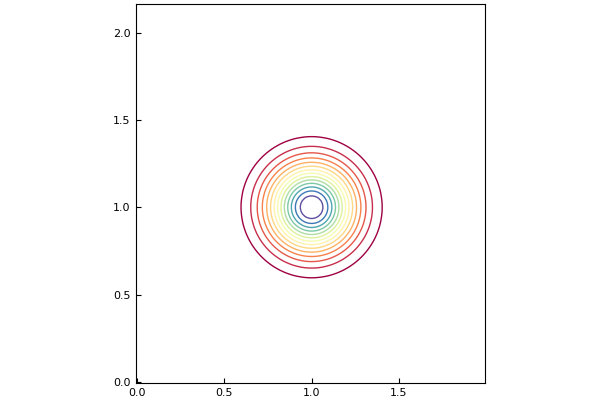

In [104]:
plot(xg,yg,w)

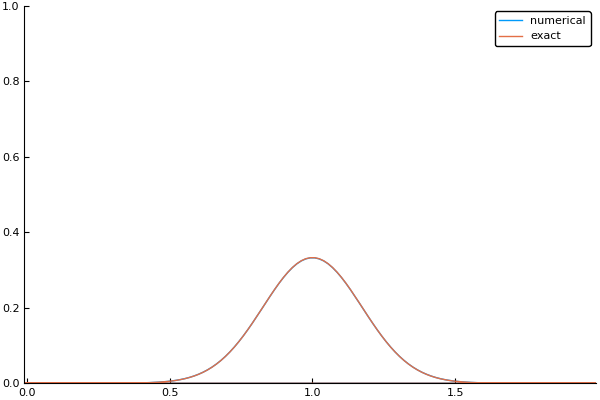

In [107]:
plot(xg,w[65,:],label="numerical",ylim=(0,1))
plot!(xg,wex(tf)[65,:],label="exact")